June 27th 2024  
Use the weights to calculate the average connectivity profile in various ways and save them. This code tests manually too.

In [1]:
import sys, os, glob
import datetime, time

import numpy as np
from numpy import linalg as nla
#import scipy.linalg as sla
import numpy.random as nrd

# import scipy.stats as sst

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import scipy.io as sio
from scipy.stats import wilcoxon
from scipy.stats import binom

from collections import defaultdict

gen_fns_dir = os.path.abspath('../shared')
sys.path.append(gen_fns_dir)
from general_file_fns import load_pickle_file, save_pickle_file
import conn_data_analysis_fns as cdaf

curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'
#sd=int((time.time()%1)*(2**31))
# rng = nrd.default_rng(sd)
# print('Seed= ',sd)

In [2]:
data_path = '../../results/2024_06_26/delta7_rec_matrices/'
fname = 'delta7_delta7_connections_rec_matrices_with_normalized_weights.p'
conn_matrices = load_pickle_file(data_path + fname)


In [3]:
neuron_list = conn_matrices['neuron_list']
subtype_list = conn_matrices['subtype_list']
subtype_idx = conn_matrices['subtype_idx']
raw_conn_matrix = conn_matrices['raw_conn_matrix']
norm_conn_matrix = conn_matrices['norm_conn_matrix']

In [4]:
S_fn = cdaf.gather_over_subtype(norm_conn_matrix.T, subtype_list, subtype_idx)

In [5]:
# Compute manually.
# Note that this version has pre on rows, so is transpose
W = norm_conn_matrix.T
S_manual = np.zeros((len(subtype_list), len(subtype_list)))
for i, source_subt in enumerate(subtype_list):
    source_sub_idx = subtype_idx[source_subt]
#     print(i, source_subt, source_sub_idx)
    
    # Fictive activity vector in which neurons of this subtype
    # are active and everyone is silent
    x = np.zeros(len(neuron_list))
    x[source_sub_idx] = 1.
    
    # What inhibition does everyone else feel if this were the
    # network state?
    y = W @ x

    # Now we want to average this by subtype to ask what average
    # inhibition is felt by neurons of each subtype
    for j, target_subt in enumerate(subtype_list):
        target_sub_idx = subtype_idx[target_subt]
        S_manual[i,j] = np.mean(y[target_sub_idx])

print(np.allclose(S_manual, S_fn.T))

True


In [6]:
shifted_S = cdaf.diag_align(S_fn, offset=5)
avg_profile_fn = np.mean(shifted_S, axis=0)

In [7]:
avg_profile_manual = np.zeros_like(S_fn[0])
for i in range(len(S_fn)):
    vc1 = np.roll(S_fn[i], -i+5)
#     print(vc1 - shifted_S[i])
    avg_profile_manual = avg_profile_manual + vc1

avg_profile_manual = avg_profile_manual/len(S_fn)

print(np.allclose(avg_profile_fn, avg_profile_manual))

True


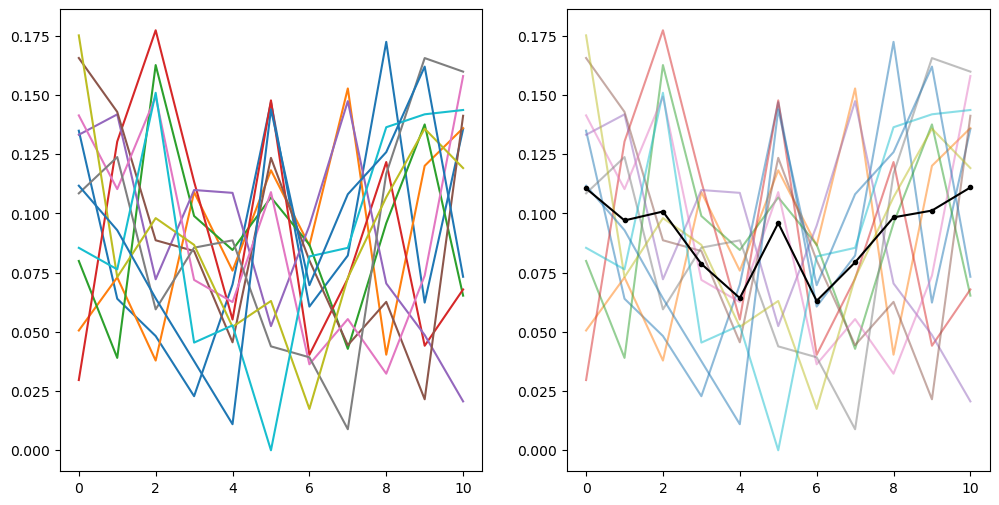

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(shifted_S)):
    ax[0].plot(np.arange(len(shifted_S[i])), shifted_S[i])
    ax[1].plot(np.arange(len(shifted_S[i])), shifted_S[i], alpha=0.5)

ax[1].plot(np.arange(len(shifted_S[i])), avg_profile_fn, color='k', marker='.')


In [12]:
left_glom_idx = defaultdict(list)
right_glom_idx = defaultdict(list)

for subtype in subtype_list:
    rel_nrn_idx = subtype_idx[subtype]
    x = subtype[13:] # Get rid of first part of string
    l_glom = x.partition('R')[0]
    r_glom = ('R' + x.partition('R')[2])[:-2]
    print(subtype, l_glom, r_glom)
    
    left_glom_idx[l_glom].extend(rel_nrn_idx)
    right_glom_idx[r_glom].extend(rel_nrn_idx)

left_glom_list = sorted(left_glom_idx.keys())
right_glom_list = sorted(right_glom_idx.keys())

Delta7(PB15)_L1L9R8_R L1L9 R8
Delta7(PB15)_L2R7_R L2 R7
Delta7(PB15)_L3R6_R L3 R6
Delta7(PB15)_L4R5_R L4 R5
Delta7(PB15)_L4R6_R L4 R6
Delta7(PB15)_L5R4_L L5 R4
Delta7(PB15)_L6R3_L L6 R3
Delta7(PB15)_L6R4_L L6 R4
Delta7(PB15)_L7R2_L L7 R2
Delta7(PB15)_L7R3_L L7 R3
Delta7(PB15)_L8R1R9_L L8 R1R9


In [13]:
left_glom_list

['L1L9', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']

In [14]:
right_glom_list

['R1R9', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']

In [27]:
print([(k[13:-2], len(v)) for k, v in subtype_idx.items()])
print('\n')
print([(k, len(v)) for k, v in left_glom_idx.items()])
print([(k, len(v)) for k, v in right_glom_idx.items()])

[('L1L9R8', 5), ('L2R7', 5), ('L3R6', 4), ('L4R5', 5), ('L4R6', 2), ('L5R4', 5), ('L6R3', 5), ('L6R4', 2), ('L7R2', 3), ('L7R3', 1), ('L8R1R9', 5)]


[('L1L9', 5), ('L2', 5), ('L3', 4), ('L4', 7), ('L5', 5), ('L6', 7), ('L7', 4), ('L8', 5)]
[('R8', 5), ('R7', 5), ('R6', 6), ('R5', 5), ('R4', 7), ('R3', 6), ('R2', 3), ('R1R9', 5)]


In [16]:
right_glom_idx

defaultdict(list,
            {'R8': [0, 1, 2, 3, 4],
             'R7': [5, 6, 7, 8, 9],
             'R6': [10, 11, 12, 13, 19, 20],
             'R5': [14, 15, 16, 17, 18],
             'R4': [21, 22, 23, 24, 25, 31, 32],
             'R3': [26, 27, 28, 29, 30, 36],
             'R2': [33, 34, 35],
             'R1R9': [37, 38, 39, 40, 41]})

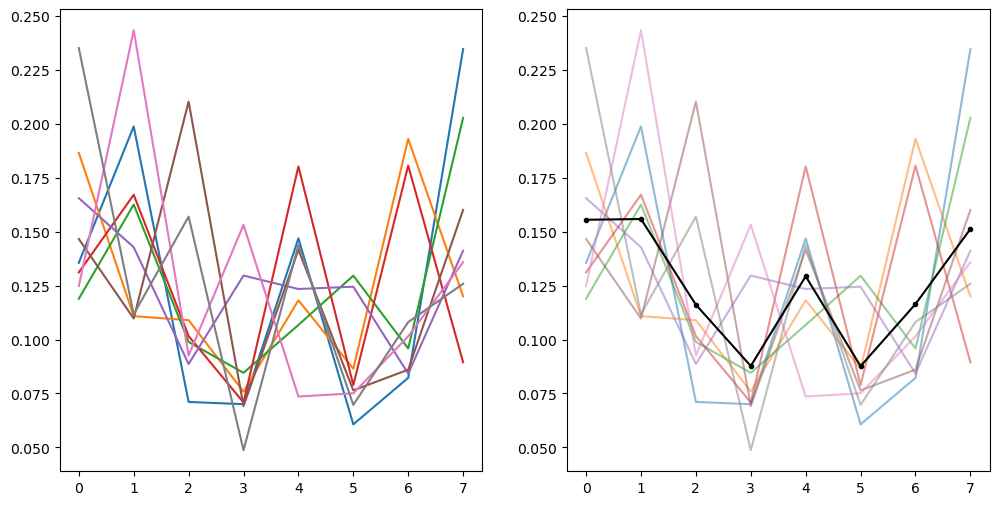

In [17]:
S_left = cdaf.gather_over_subtype(norm_conn_matrix.T, left_glom_list, left_glom_idx)
shifted_S_left = cdaf.diag_align(S_left, offset=4)
avg_profile_left = np.mean(shifted_S_left, axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(shifted_S_left)):
    ax[0].plot(np.arange(len(shifted_S_left[i])), shifted_S_left[i])
    ax[1].plot(np.arange(len(shifted_S_left[i])), shifted_S_left[i], alpha=0.5)

ax[1].plot(np.arange(len(shifted_S_left[i])), avg_profile_left, color='k', marker='.')

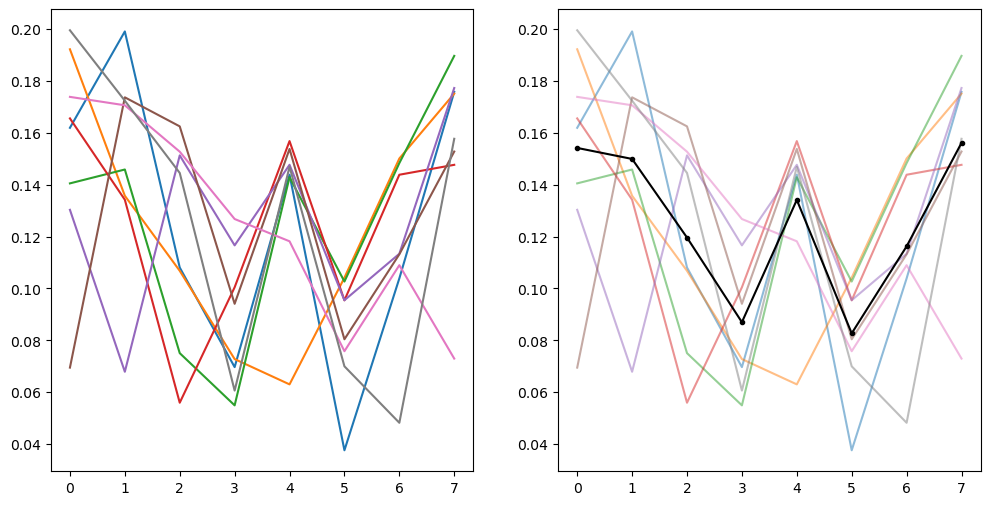

In [18]:
S_right = cdaf.gather_over_subtype(norm_conn_matrix.T, right_glom_list, right_glom_idx)
shifted_S_right = cdaf.diag_align(S_right, offset=4)
avg_profile_right = np.mean(shifted_S_right, axis=0)

fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(shifted_S_right)):
    ax[0].plot(np.arange(len(shifted_S_right[i])), shifted_S_right[i])
    ax[1].plot(np.arange(len(shifted_S_right[i])), shifted_S_right[i], alpha=0.5)

ax[1].plot(np.arange(len(shifted_S_right[i])), avg_profile_right, color='k', marker='.')

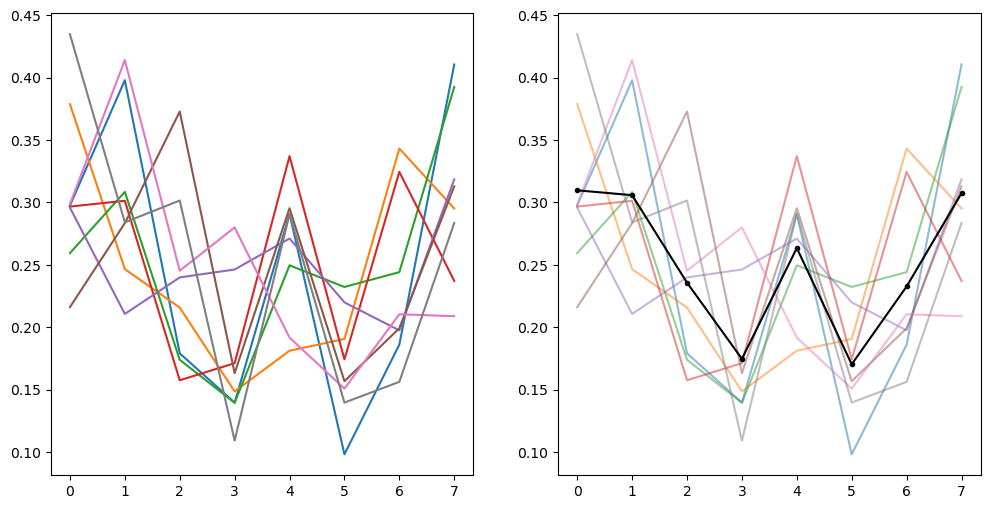

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(shifted_S_right)):
    ax[0].plot(np.arange(len(shifted_S_right[i])), shifted_S_left[i] + shifted_S_right[i])
    ax[1].plot(np.arange(len(shifted_S_right[i])), shifted_S_left[i] + shifted_S_right[i], alpha=0.5)

ax[1].plot(np.arange(len(shifted_S_right[i])), avg_profile_left + avg_profile_right, color='k', marker='.')